In [1]:
%matplotlib inline
import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.15)

In [2]:
with h5py.File('elm-events.hdf5', 'r') as f:
    ids = list(f.keys())
    signal_1 = np.array(f[ids[0]]['signals'])
    time_1 = np.array(f[ids[0]]['time'])

    signal_2 = np.array(f[ids[2]]['signals'])
    time_2 = np.array(f[ids[2]]['time'])

signal_1 = signal_1.T
signal_2 = signal_2.T

In [3]:
def normalize_data(signal:np.ndarray):
    assert signal.shape[1] == 64, 'Signal must be reshaped into (-1, 64)'
    signal[:, :32] = signal[:, :32] / np.max(signal[:, :32])
    signal[:, 32:] = signal[:, 32:] / np.max(signal[:, 32:])
    return signal


In [4]:
signal_1_normalized = normalize_data(signal_1)
signal_2_normalized = normalize_data(signal_2)

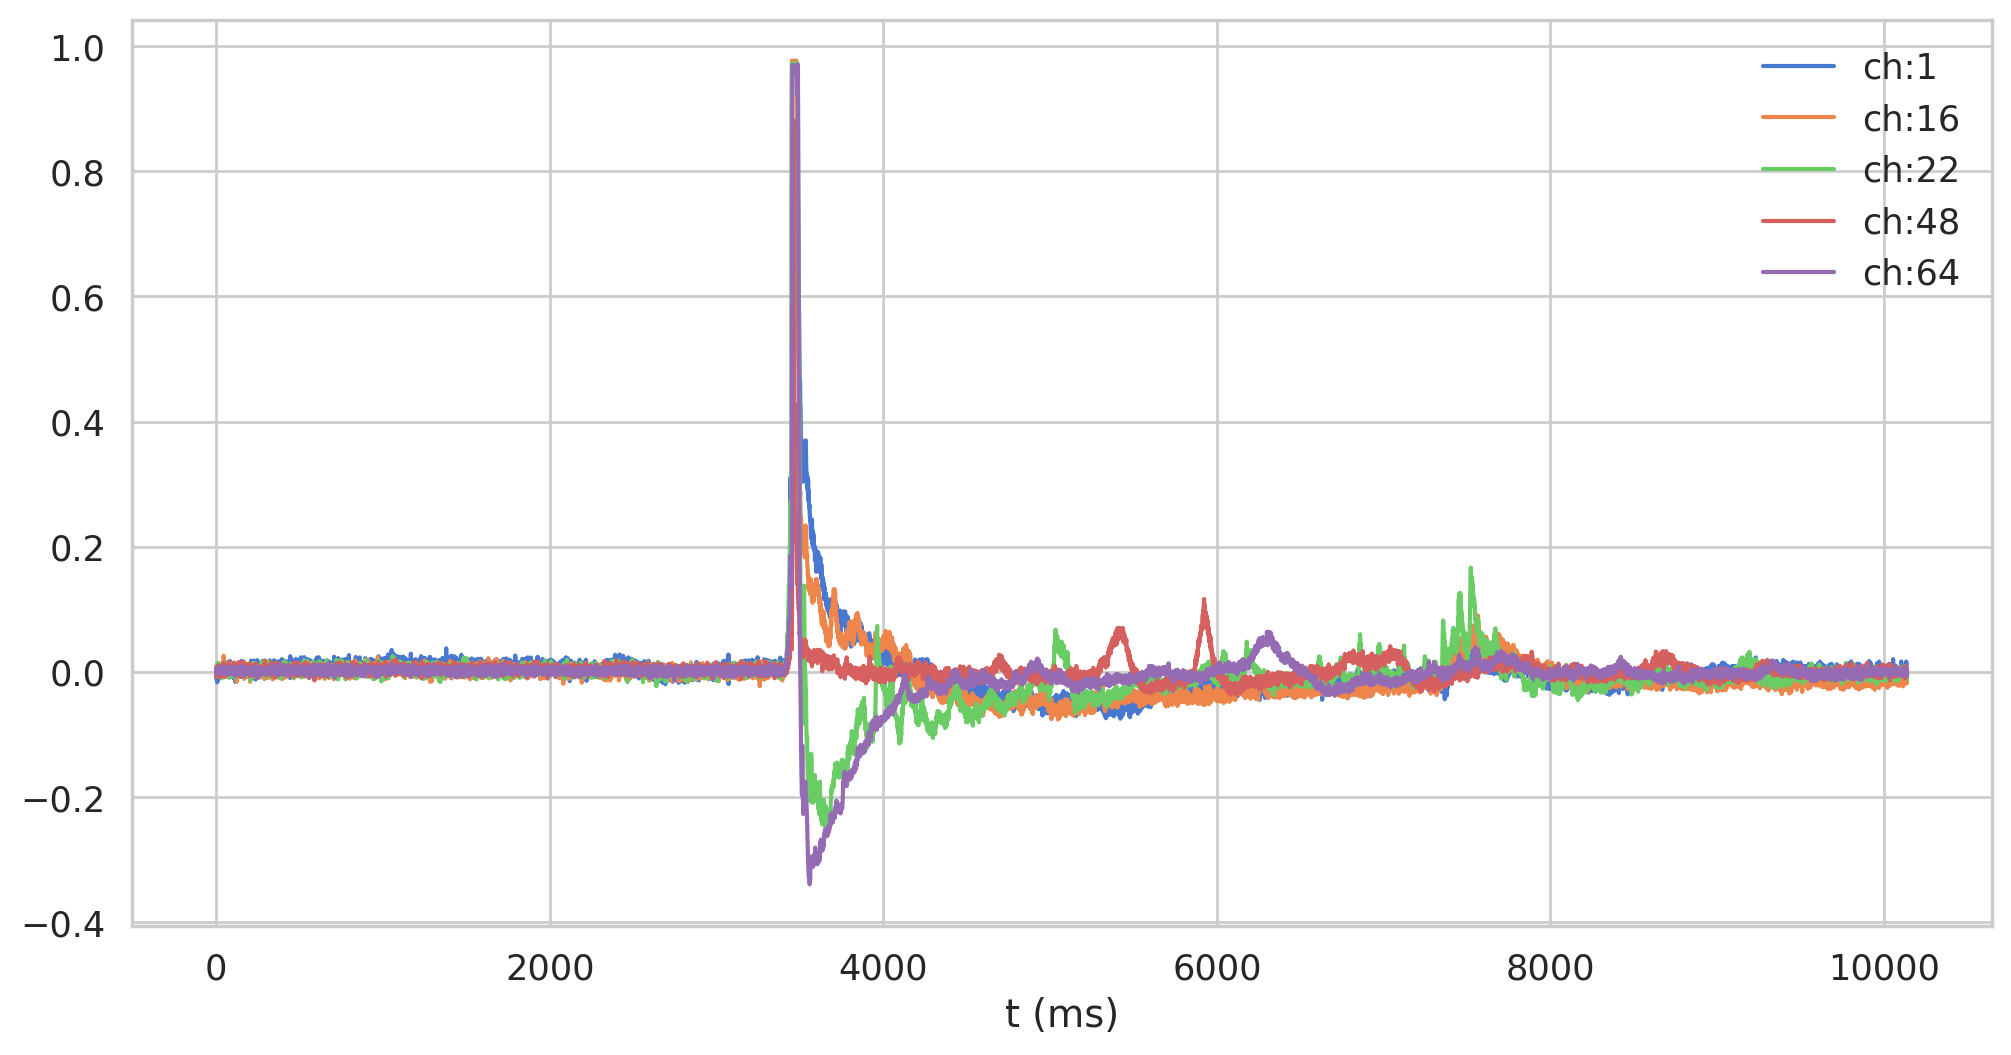

In [5]:
plt.figure(figsize=(12, 6), dpi=200)

for i in [0, 15, 21, 47, 63]:
    plt.plot(signal_1[:, i], label=f'ch:{i+1}')
plt.legend(frameon=False)
plt.xlabel('t (ms)')
plt.show()

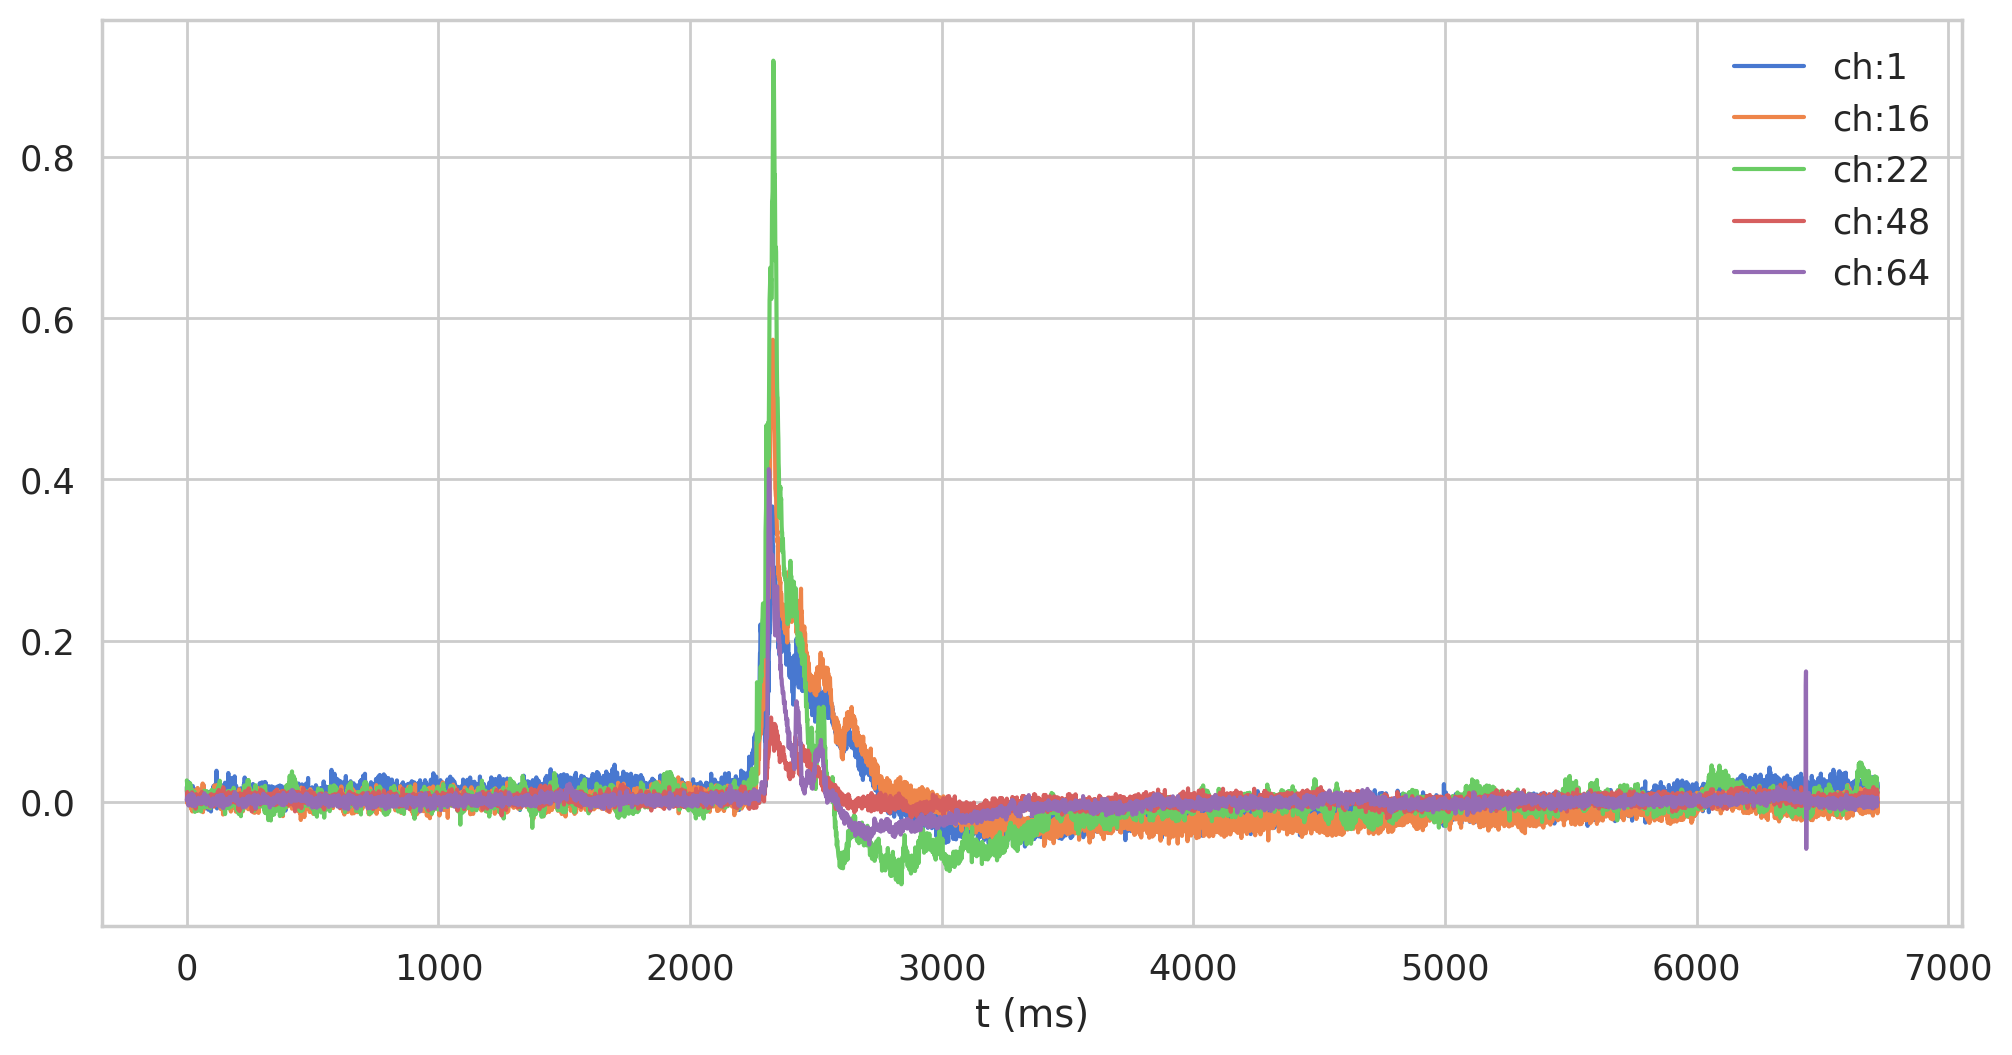

In [6]:
plt.figure(figsize=(12, 6), dpi=200)

for i in [0, 15, 21, 47, 63]:
    plt.plot(signal_2[:, i], label=f'ch:{i+1}')
plt.legend(frameon=False)
plt.xlabel('t (ms)')
plt.show()

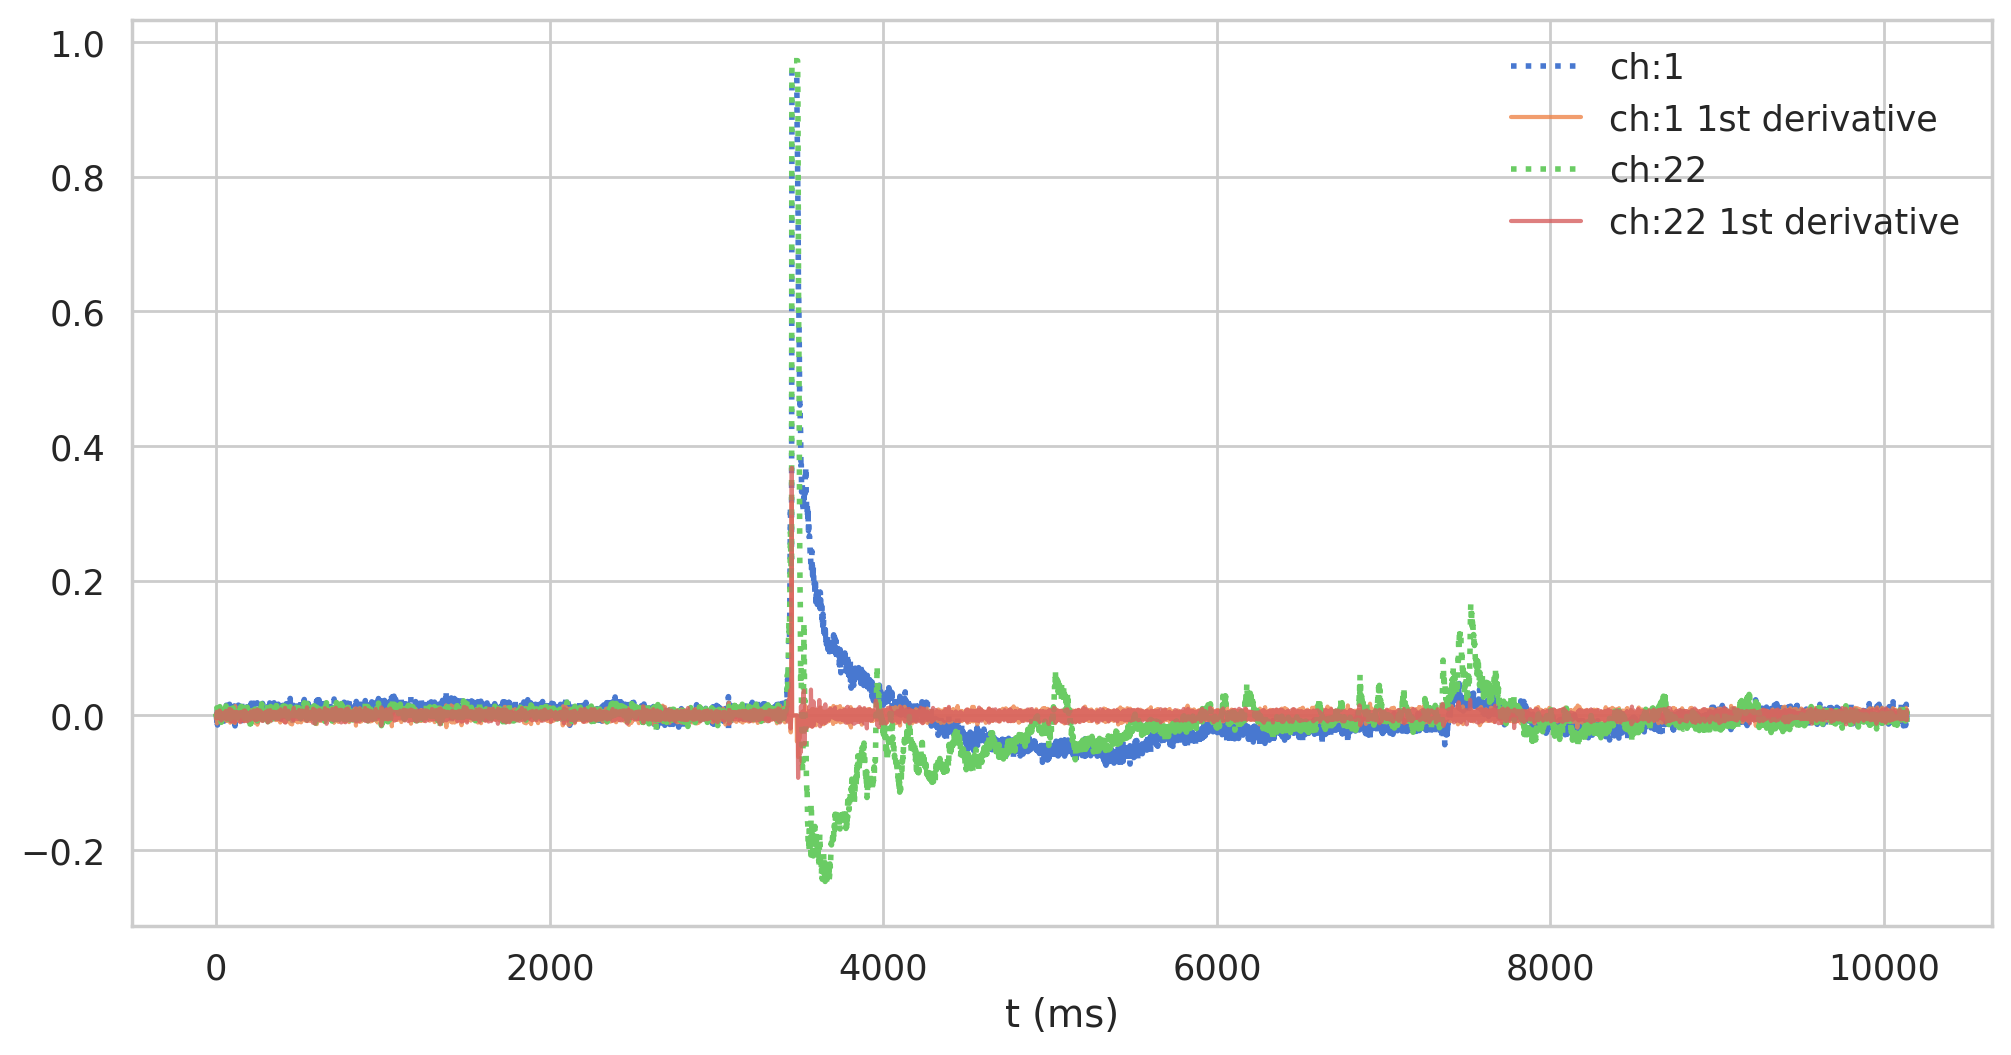

In [7]:
time_grads = np.gradient(signal_1, axis=0)
plt.figure(figsize=(12, 6), dpi=200)

plt.plot(signal_1[:, 0], ls=':', lw=2, label=f'ch:1')
plt.plot(time_grads[:, 0], ls='-', label='ch:1 1st derivative', alpha=0.8)

plt.plot(signal_1[:, 21], ls=':', lw=2, label=f'ch:22')
plt.plot(time_grads[:, 21], ls='-', label='ch:22 1st derivative', alpha=0.8)

plt.legend(frameon=False)
plt.xlabel('t (ms)')
plt.show()

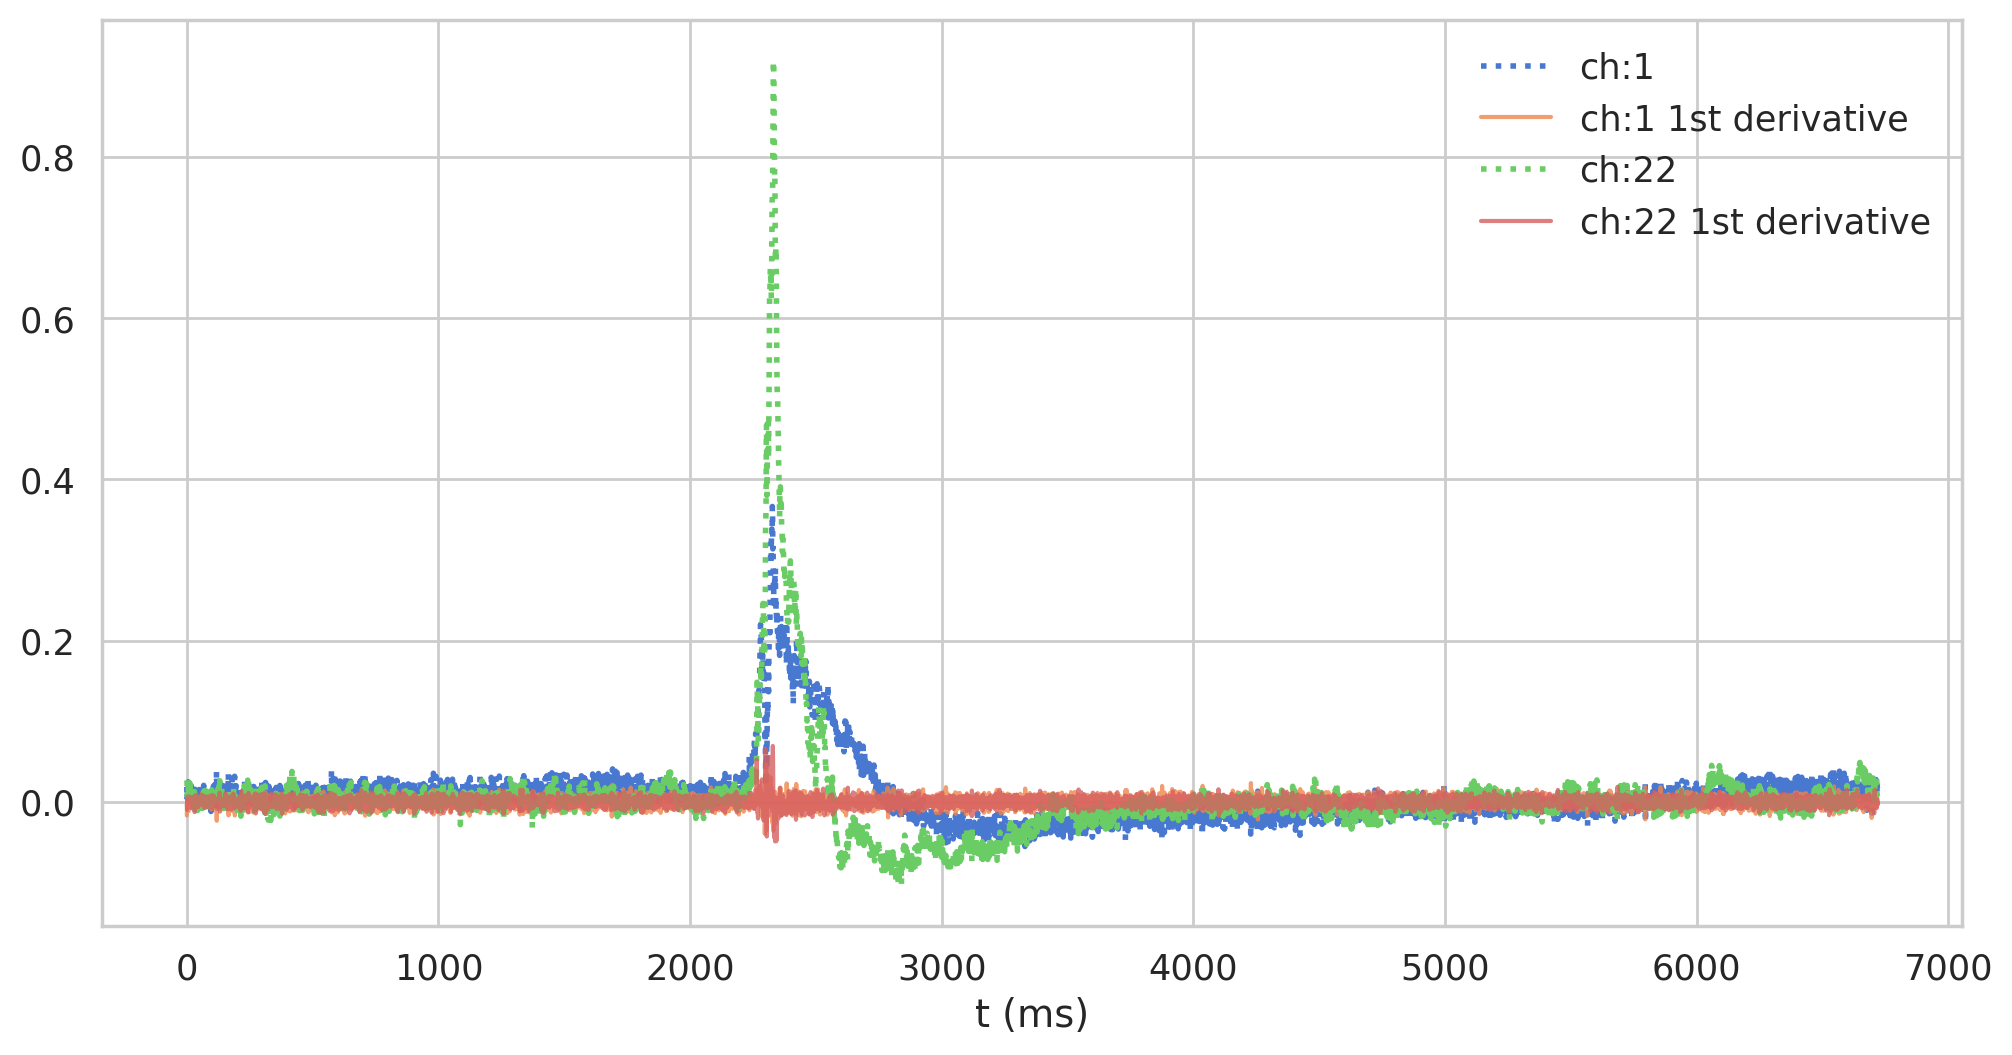

In [8]:
time_grads = np.gradient(signal_2, axis=0)
plt.figure(figsize=(12, 6), dpi=200)

plt.plot(signal_2[:, 0], ls=':', lw=2, label=f'ch:1')
plt.plot(time_grads[:, 0], ls='-', label='ch:1 1st derivative', alpha=0.8)

plt.plot(signal_2[:, 21], ls=':', lw=2, label=f'ch:22')
plt.plot(time_grads[:, 21], ls='-', label='ch:22 1st derivative', alpha=0.8)

plt.legend(frameon=False)
plt.xlabel('t (ms)')
plt.show()

In [9]:
class Encoder(nn.Module):
    def __init__(
        self,
        hidden_dim: int,
        seq_len: int,
        n_features: int,
        n_layers: int,
        dropout: float,
    ):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.rnn = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            batch_first=True,
            num_layers=self.n_layers,
            dropout=self.dropout,
        )

    def forward(self, x):
        _, (hidden, _) = self.rnn(x)
        # hidden size: (num_layers, batch_size, hidden_size)
        # hidden = hidden.reshape(
        #     batch_size, -1
        # )  # (batch_size, num_layers*hidden_size)
        hidden = (
            hidden.transpose(0, 1)
            .contiguous()
            .view(-1, self.n_layers * self.hidden_dim)
        )
        return hidden


class Decoder(nn.Module):
    def __init__(
        self,
        hidden_dim: int,
        seq_len: int,
        n_features: int,
        n_layers: int,
        dropout: float,
    ):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.rnn = nn.LSTM(
            input_size=self.n_layers * self.hidden_dim,
            hidden_size=self.hidden_dim,
            batch_first=True,
            num_layers=self.n_layers,
            dropout=self.dropout,
        )
        self.fc = nn.Linear(self.hidden_dim, self.n_features)

    def forward(self, x):
        # x: (batch_size, num_layers*hidden_size)
        x = x.repeat(1, self.seq_len, 1)
        x = x.reshape(-1, self.seq_len, self.n_layers * self.hidden_dim)
        x, _ = self.rnn(x)  # x: (batch_size, seq_len, hidden_dim)
        x = self.fc(x)  # x: (batch_size, seq_len, n_features)

        return x


class LSTMAutoencoder(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions for both encoder and decoder must be equal"

        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder should have same number of layers"

    def forward(self, input):
        # input = torch.unsqueeze(input, 0)
        # encode
        hidden = self.encoder(input)
        # decode
        y = self.decoder(hidden)

        return y.squeeze(0)

In [10]:
def temporalize(sws:int, signals:np.ndarray):
    X_unlabeled = []
    for i in range(len(signals) - sws + 1):
        X_unlabeled.append(signals[i:i+sws])
    X_unlabeled = np.array(X_unlabeled)
    return X_unlabeled

In [11]:
seq_len = 16
n_features = 64
n_layers = 2
pct = 0.3
hidden_dim = 32
encoder = Encoder(
    hidden_dim=hidden_dim,
    seq_len=seq_len,
    n_features=n_features,
    n_layers=n_layers,
    dropout=pct,
)
decoder = Decoder(
    hidden_dim=hidden_dim,
    seq_len=seq_len,
    n_features=n_features,
    n_layers=n_layers,
    dropout=pct,
)
model = LSTMAutoencoder(encoder, decoder)
model

LSTMAutoencoder(
  (encoder): Encoder(
    (rnn): LSTM(64, 32, num_layers=2, batch_first=True, dropout=0.3)
  )
  (decoder): Decoder(
    (rnn): LSTM(64, 32, num_layers=2, batch_first=True, dropout=0.3)
    (fc): Linear(in_features=32, out_features=64, bias=True)
  )
)

In [12]:
base_path = os.path.dirname(os.getcwd())
saved_model_path = 'elm_classification/model_checkpoints/signal_window_16/lstm_ae_sws_16_la_0.pth'
model_ckpt_path = os.path.join(base_path, saved_model_path)
print(f'Loading model from:\n{model_ckpt_path}')
device = torch.device("cpu")
model = model.to(device)
model.load_state_dict(
        torch.load(
            model_ckpt_path,
            map_location=device,
        )
    )

Loading model from:
/home/lakshya/research/bes_edgeml_models/elm_classification/model_checkpoints/signal_window_16/lstm_ae_sws_16_la_0.pth


<All keys matched successfully>

In [13]:
X_unlabeled = temporalize(sws=seq_len, signals=signal_1_normalized)
signal_tensor = torch.as_tensor(X_unlabeled, dtype=torch.float32)
unlabeled_dataset = torch.utils.data.TensorDataset(signal_tensor)
data_loader = torch.utils.data.DataLoader(
    unlabeled_dataset, batch_size=1, num_workers=0
)
input = next(iter(data_loader))[0]
input.shape

torch.Size([1, 16, 64])

In [14]:
sequences = []
mae = []
for data in data_loader:
    seq = data[0]
    sequences.append(seq[0, 0, 21].cpu().numpy().tolist())
    pred_seq = model(seq)
    loss = torch.mean(torch.abs(torch.squeeze(seq, 0) - pred_seq))
    mae.append(loss.cpu().detach().numpy())
mae = np.array(mae)

threshold = 0.023
error_df = pd.DataFrame(
        {
            "reconstruction_error": mae,
            "reconstruction_error_scaled": mae / np.max(mae),
            "ch_22": sequences,
        }
    )
predictions = (error_df.reconstruction_error.values > threshold).astype(int)
error_df["predictions"] = predictions
error_df

,reconstruction_error,reconstruction_error_scaled,ch_22,predictions
0,0.006988,0.009417,0.002255,0
1,0.007123,0.009599,-0.001543,0
2,0.006731,0.009071,0.002968,0
3,0.006930,0.009339,-0.000356,0
4,0.007243,0.009760,0.011277,0
...,...,...,...,...
10119,0.006281,0.008464,0.002137,0
10120,0.006730,0.009070,0.001543,0
10121,0.006783,0.009141,0.001543,0
10122,0.006358,0.008568,0.000356,0


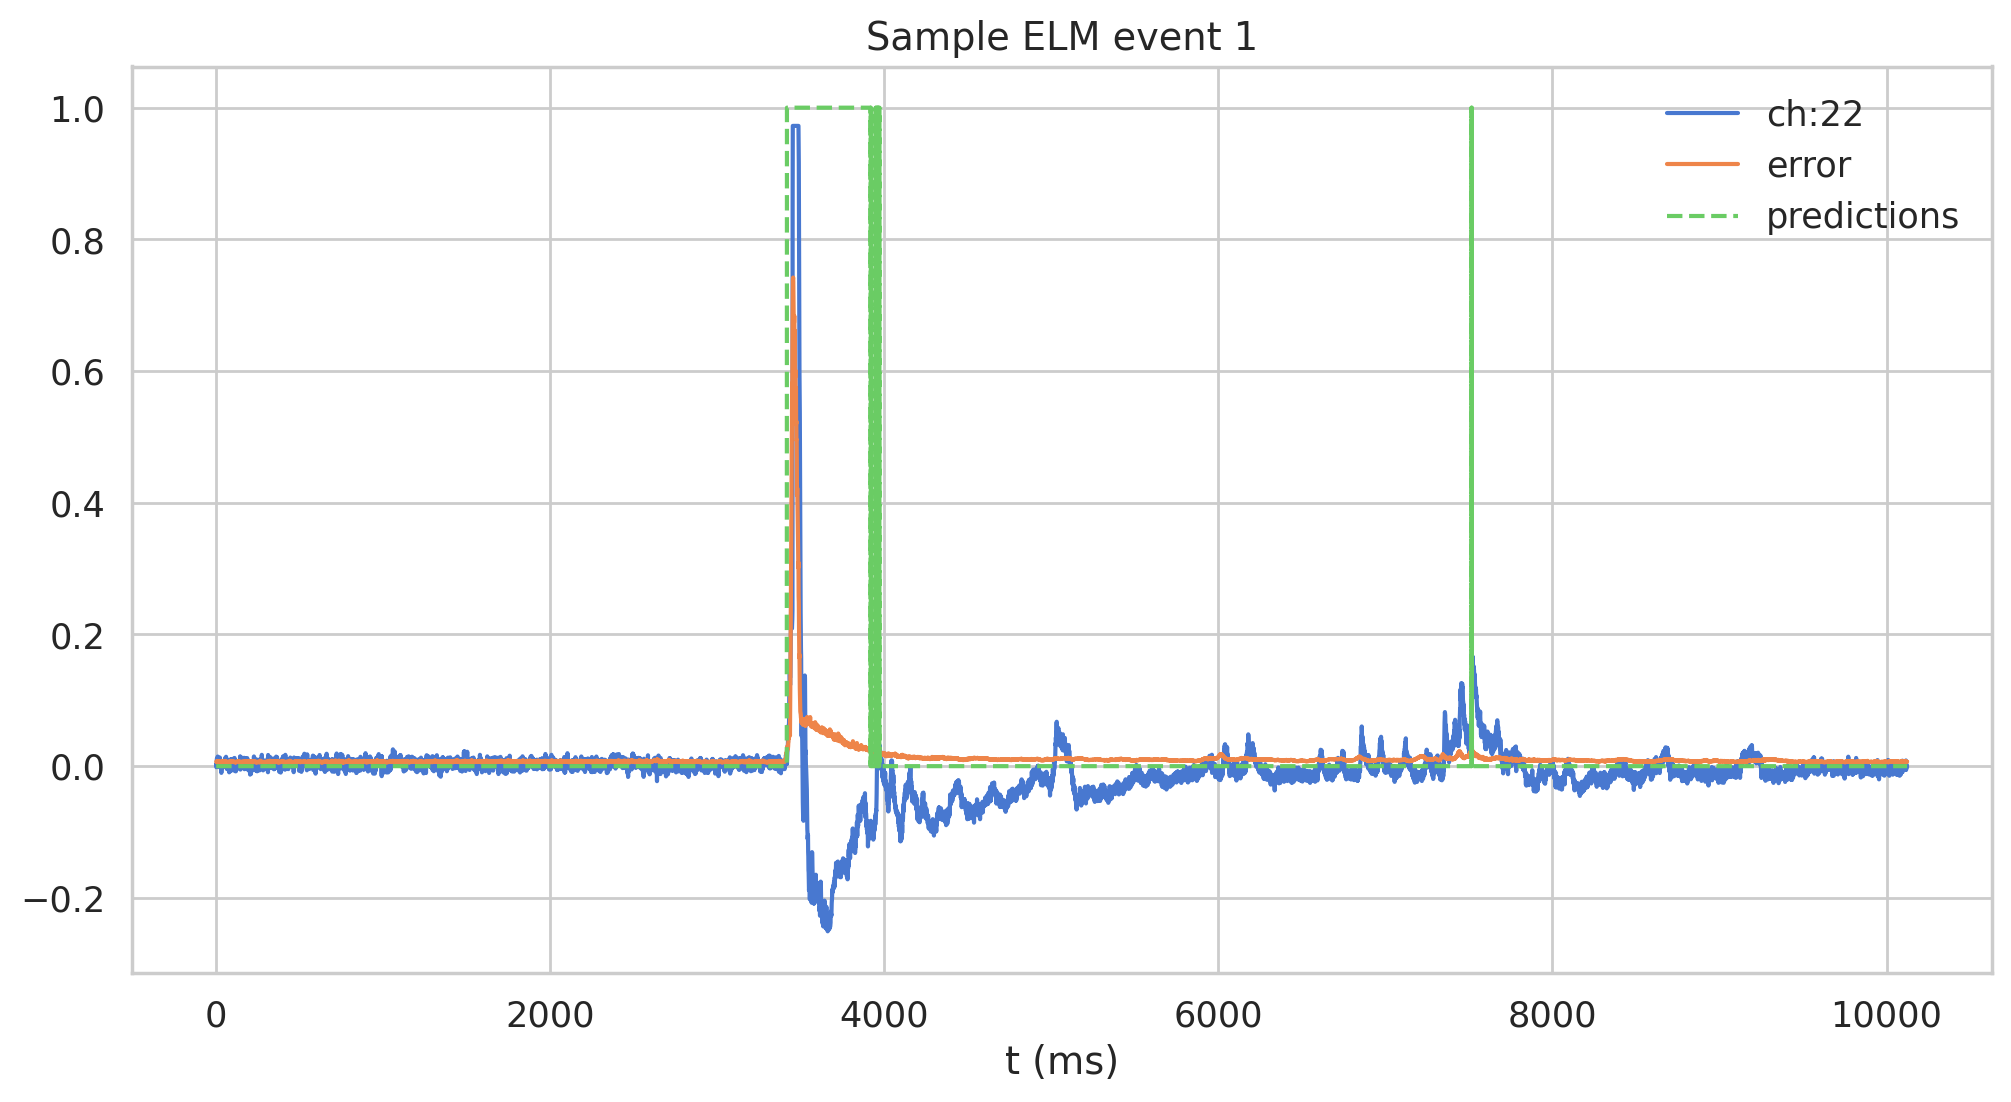

In [15]:
plt.figure(figsize=(12, 6), dpi=200)

plt.plot(error_df.ch_22, label='ch:22')
plt.plot(error_df.reconstruction_error, label='error')
plt.plot(error_df.predictions, ls='--', label='predictions')
plt.legend(frameon=False)
plt.title('Sample ELM event 1')
plt.xlabel('t (ms)')
plt.show()

In [16]:
X_unlabeled = temporalize(sws=seq_len, signals=signal_2_normalized)
signal_tensor = torch.as_tensor(X_unlabeled, dtype=torch.float32)
unlabeled_dataset = torch.utils.data.TensorDataset(signal_tensor)
data_loader = torch.utils.data.DataLoader(
    unlabeled_dataset, batch_size=1, num_workers=0
)
input = next(iter(data_loader))[0]
input.shape

torch.Size([1, 16, 64])

In [17]:
sequences = []
mae = []
for data in data_loader:
    seq = data[0]
    sequences.append(seq[0, 0, 21].cpu().numpy().tolist())
    pred_seq = model(seq)
    loss = torch.mean(torch.abs(torch.squeeze(seq, 0) - pred_seq))
    mae.append(loss.cpu().detach().numpy())
mae = np.array(mae)

threshold = 0.023
error_df = pd.DataFrame(
        {
            "reconstruction_error": mae,
            "reconstruction_error_scaled": mae / np.max(mae),
            "ch_22": sequences,
        }
    )
predictions = (error_df.reconstruction_error.values > threshold).astype(int)
error_df["predictions"] = predictions
error_df

,reconstruction_error,reconstruction_error_scaled,ch_22,predictions
0,0.009904,0.044463,0.026689,0
1,0.010112,0.045399,0.023791,0
2,0.010204,0.045811,0.007015,0
3,0.010048,0.045111,0.018606,0
4,0.010129,0.045475,0.020588,0
...,...,...,...,...
6701,0.010065,0.045184,0.019368,0
6702,0.010133,0.045491,0.029586,0
6703,0.010160,0.045614,0.016776,0
6704,0.009870,0.044309,0.006100,0


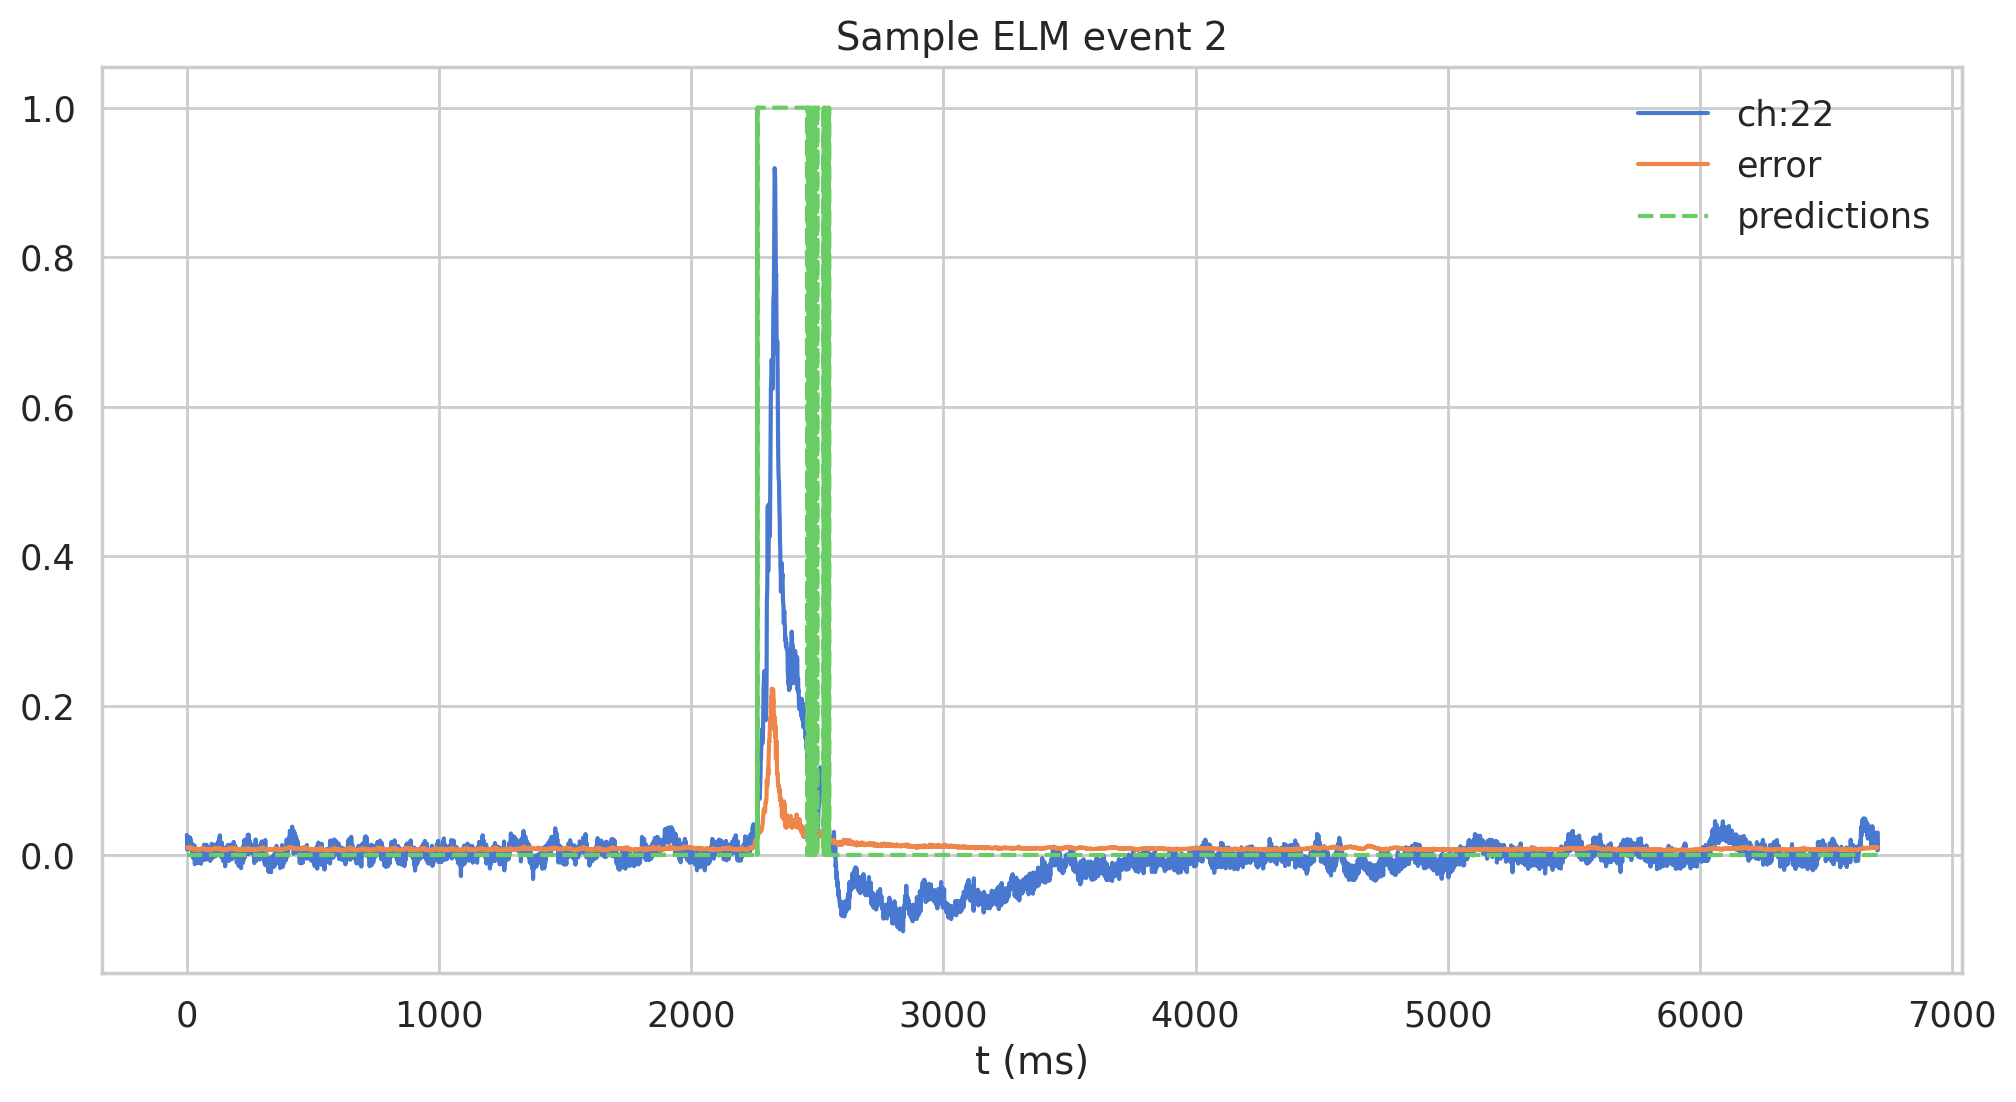

In [18]:
plt.figure(figsize=(12, 6), dpi=200)

plt.plot(error_df.ch_22, label='ch:22')
plt.plot(error_df.reconstruction_error, label='error')
plt.plot(error_df.predictions, ls='--', label='predictions')
plt.legend(frameon=False)
plt.title('Sample ELM event 2')
plt.xlabel('t (ms)')
plt.show()